In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 6:6+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/23-39/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 30  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(17, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(17, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 17)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 17)
valid_labels[0].shape = (224, 224, 1)



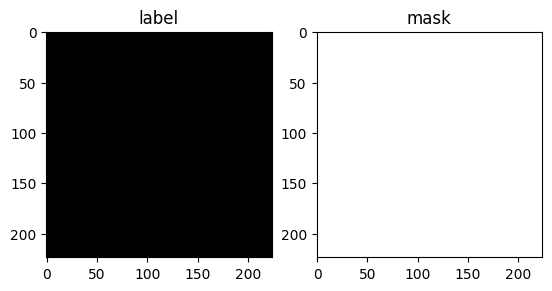

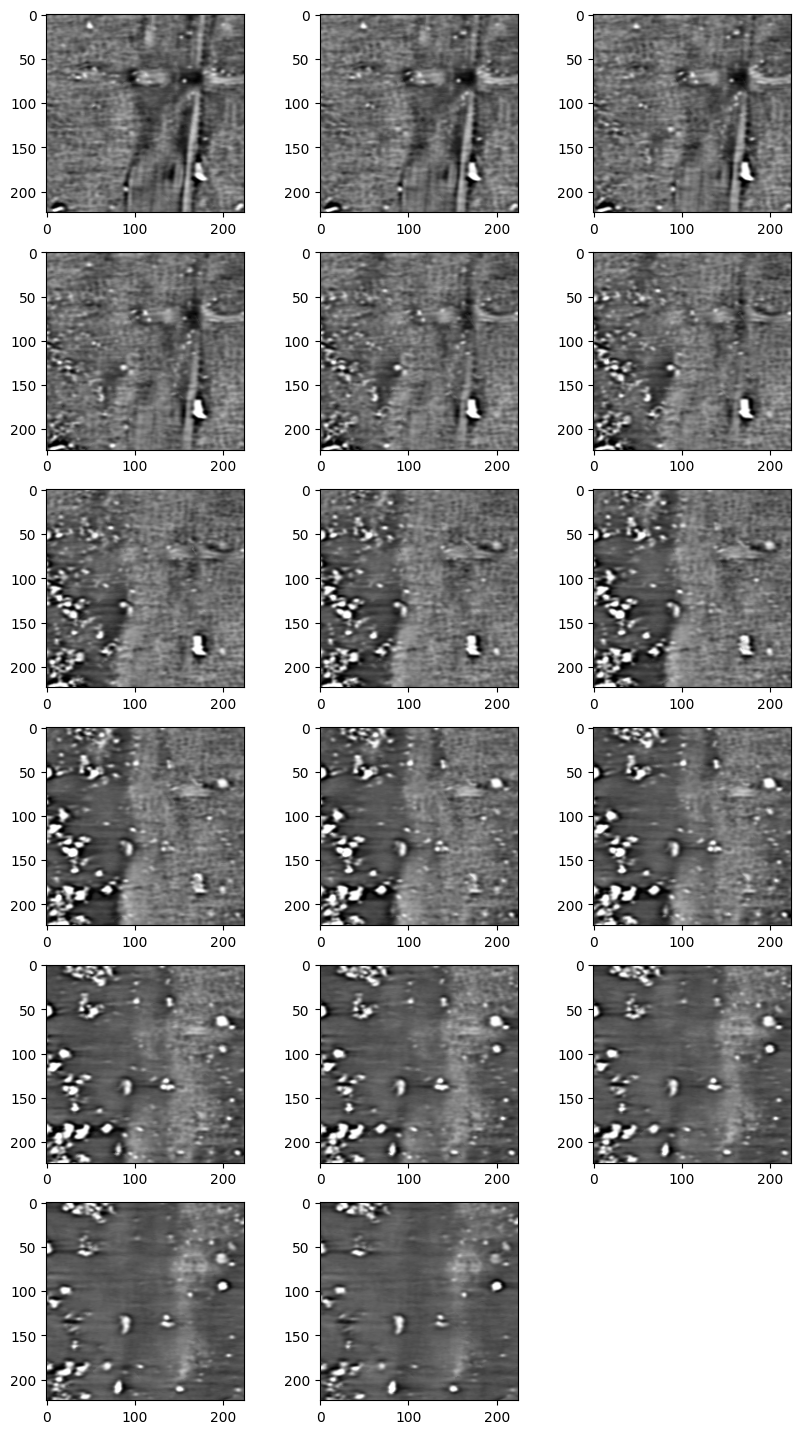

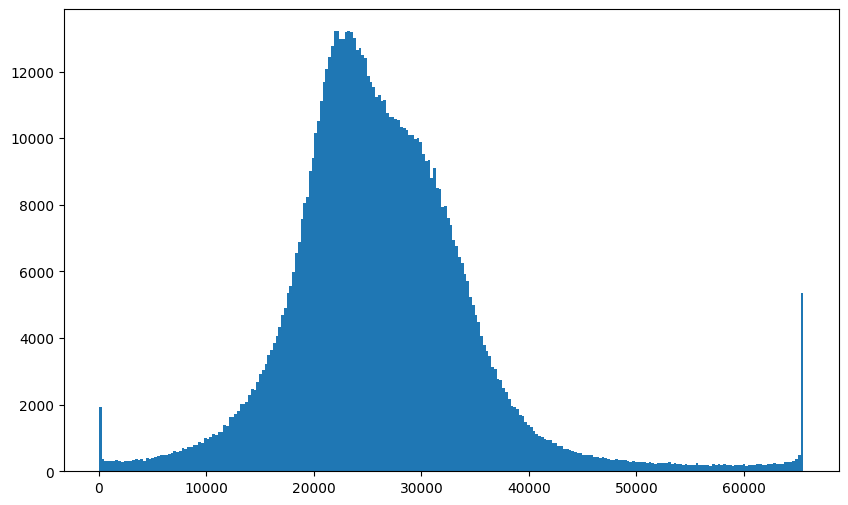

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


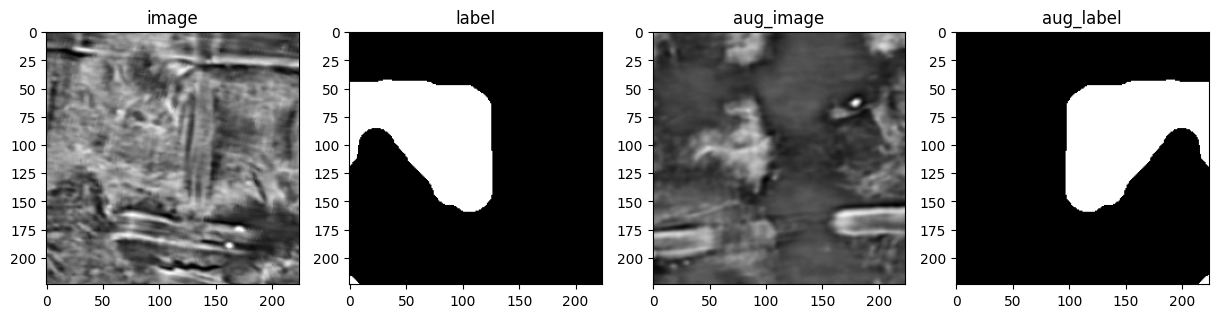

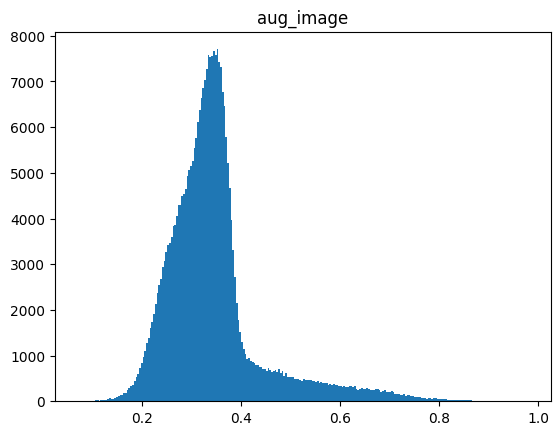

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|██████████| 131/131 [00:08<00:00, 14.99it/s]


fbeta: 0.3421
Epoch 1 - avg_train_loss: 1.3929  avg_val_loss: 1.1225  avgScore: 0.3421  time: 89s
Epoch 1 - Save Best Loss: 1.1225  Best Score: 0.3421 Model



100%|██████████| 131/131 [00:07<00:00, 18.06it/s]


fbeta: 0.3311
Epoch 2 - avg_train_loss: 1.2011  avg_val_loss: 1.1312  avgScore: 0.3311  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.16it/s]


fbeta: 0.4119
Epoch 3 - avg_train_loss: 1.0407  avg_val_loss: 0.9319  avgScore: 0.4119  time: 79s
Epoch 3 - Save Best Loss: 0.9319  Best Score: 0.4119 Model



100%|██████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.4031
Epoch 4 - avg_train_loss: 0.9510  avg_val_loss: 0.8735  avgScore: 0.4031  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.13it/s]


fbeta: 0.3385
Epoch 5 - avg_train_loss: 0.8998  avg_val_loss: 1.0061  avgScore: 0.3385  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.05it/s]


fbeta: 0.3781
Epoch 6 - avg_train_loss: 0.8781  avg_val_loss: 0.9413  avgScore: 0.3781  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.05it/s]


fbeta: 0.4655
Epoch 7 - avg_train_loss: 0.8549  avg_val_loss: 0.8711  avgScore: 0.4655  time: 79s
Epoch 7 - Save Best Loss: 0.8711  Best Score: 0.4655 Model



100%|██████████| 131/131 [00:07<00:00, 18.04it/s]


fbeta: 0.4998
Epoch 8 - avg_train_loss: 0.8414  avg_val_loss: 0.8300  avgScore: 0.4998  time: 78s
Epoch 8 - Save Best Loss: 0.8300  Best Score: 0.4998 Model



100%|██████████| 131/131 [00:07<00:00, 17.77it/s]


fbeta: 0.3660
Epoch 9 - avg_train_loss: 0.8019  avg_val_loss: 1.1016  avgScore: 0.3660  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.04it/s]


fbeta: 0.4712
Epoch 10 - avg_train_loss: 0.8102  avg_val_loss: 0.9714  avgScore: 0.4712  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.03it/s]


fbeta: 0.3902
Epoch 11 - avg_train_loss: 0.7925  avg_val_loss: 0.9727  avgScore: 0.3902  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.15it/s]


fbeta: 0.5036
Epoch 12 - avg_train_loss: 0.7738  avg_val_loss: 0.8448  avgScore: 0.5036  time: 79s
Epoch 12 - Save Best Loss: 0.8448  Best Score: 0.5036 Model



100%|██████████| 131/131 [00:07<00:00, 17.80it/s]


fbeta: 0.4732
Epoch 13 - avg_train_loss: 0.7628  avg_val_loss: 0.8596  avgScore: 0.4732  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.12it/s]


fbeta: 0.5476
Epoch 14 - avg_train_loss: 0.7292  avg_val_loss: 0.8725  avgScore: 0.5476  time: 79s
Epoch 14 - Save Best Loss: 0.8725  Best Score: 0.5476 Model



100%|██████████| 131/131 [00:07<00:00, 17.79it/s]


fbeta: 0.4884
Epoch 15 - avg_train_loss: 0.7376  avg_val_loss: 0.8536  avgScore: 0.4884  time: 80s



100%|██████████| 131/131 [00:07<00:00, 18.18it/s]


fbeta: 0.4875
Epoch 16 - avg_train_loss: 0.7176  avg_val_loss: 0.8633  avgScore: 0.4875  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.4309
Epoch 17 - avg_train_loss: 0.7090  avg_val_loss: 0.9177  avgScore: 0.4309  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.4946
Epoch 18 - avg_train_loss: 0.6895  avg_val_loss: 0.8488  avgScore: 0.4946  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.16it/s]


fbeta: 0.5075
Epoch 19 - avg_train_loss: 0.6860  avg_val_loss: 0.8236  avgScore: 0.5075  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.13it/s]


fbeta: 0.5498
Epoch 20 - avg_train_loss: 0.6585  avg_val_loss: 0.8340  avgScore: 0.5498  time: 79s
Epoch 20 - Save Best Loss: 0.8340  Best Score: 0.5498 Model



100%|██████████| 131/131 [00:07<00:00, 18.16it/s]


fbeta: 0.4906
Epoch 21 - avg_train_loss: 0.6489  avg_val_loss: 0.8824  avgScore: 0.4906  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.12it/s]


fbeta: 0.4971
Epoch 22 - avg_train_loss: 0.6442  avg_val_loss: 0.8620  avgScore: 0.4971  time: 78s



100%|██████████| 131/131 [00:07<00:00, 17.71it/s]


fbeta: 0.4364
Epoch 23 - avg_train_loss: 0.6414  avg_val_loss: 0.9186  avgScore: 0.4364  time: 80s



100%|██████████| 131/131 [00:07<00:00, 17.58it/s]


fbeta: 0.4987
Epoch 24 - avg_train_loss: 0.6197  avg_val_loss: 0.8748  avgScore: 0.4987  time: 81s



100%|██████████| 131/131 [00:07<00:00, 17.67it/s]


fbeta: 0.4774
Epoch 25 - avg_train_loss: 0.6065  avg_val_loss: 0.8854  avgScore: 0.4774  time: 81s



100%|██████████| 131/131 [00:07<00:00, 17.65it/s]


fbeta: 0.4985
Epoch 26 - avg_train_loss: 0.6058  avg_val_loss: 0.8674  avgScore: 0.4985  time: 81s



100%|██████████| 131/131 [00:07<00:00, 17.68it/s]


fbeta: 0.4857
Epoch 27 - avg_train_loss: 0.5885  avg_val_loss: 0.8827  avgScore: 0.4857  time: 81s



100%|██████████| 131/131 [00:07<00:00, 17.58it/s]


fbeta: 0.4615
Epoch 28 - avg_train_loss: 0.5905  avg_val_loss: 0.9149  avgScore: 0.4615  time: 81s



100%|██████████| 131/131 [00:07<00:00, 17.62it/s]


fbeta: 0.4772
Epoch 29 - avg_train_loss: 0.5815  avg_val_loss: 0.8913  avgScore: 0.4772  time: 80s



100%|██████████| 131/131 [00:07<00:00, 17.63it/s]


fbeta: 0.4708
Epoch 30 - avg_train_loss: 0.5720  avg_val_loss: 0.9089  avgScore: 0.4708  time: 81s

fold: 1


100%|██████████| 120/120 [00:07<00:00, 15.85it/s]


fbeta: 0.2694
Epoch 1 - avg_train_loss: 1.4274  avg_val_loss: 0.9792  avgScore: 0.2694  time: 86s
Epoch 1 - Save Best Loss: 0.9792  Best Score: 0.2694 Model



100%|██████████| 120/120 [00:07<00:00, 16.11it/s]


fbeta: 0.3811
Epoch 2 - avg_train_loss: 1.2414  avg_val_loss: 0.8615  avgScore: 0.3811  time: 85s
Epoch 2 - Save Best Loss: 0.8615  Best Score: 0.3811 Model



100%|██████████| 120/120 [00:07<00:00, 16.34it/s]


fbeta: 0.4104
Epoch 3 - avg_train_loss: 1.0460  avg_val_loss: 0.6556  avgScore: 0.4104  time: 84s
Epoch 3 - Save Best Loss: 0.6556  Best Score: 0.4104 Model



100%|██████████| 120/120 [00:07<00:00, 16.37it/s]


fbeta: 0.4751
Epoch 4 - avg_train_loss: 0.9557  avg_val_loss: 0.6461  avgScore: 0.4751  time: 83s
Epoch 4 - Save Best Loss: 0.6461  Best Score: 0.4751 Model



100%|██████████| 120/120 [00:07<00:00, 16.41it/s]


fbeta: 0.5045
Epoch 5 - avg_train_loss: 0.9182  avg_val_loss: 0.6126  avgScore: 0.5045  time: 82s
Epoch 5 - Save Best Loss: 0.6126  Best Score: 0.5045 Model



100%|██████████| 120/120 [00:07<00:00, 16.54it/s]


fbeta: 0.4702
Epoch 6 - avg_train_loss: 0.9005  avg_val_loss: 0.6253  avgScore: 0.4702  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.58it/s]


fbeta: 0.4934
Epoch 7 - avg_train_loss: 0.8597  avg_val_loss: 0.6125  avgScore: 0.4934  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.63it/s]


fbeta: 0.5148
Epoch 8 - avg_train_loss: 0.8419  avg_val_loss: 0.5910  avgScore: 0.5148  time: 81s
Epoch 8 - Save Best Loss: 0.5910  Best Score: 0.5148 Model



100%|██████████| 120/120 [00:07<00:00, 16.51it/s]


fbeta: 0.5258
Epoch 9 - avg_train_loss: 0.8280  avg_val_loss: 0.6371  avgScore: 0.5258  time: 82s
Epoch 9 - Save Best Loss: 0.6371  Best Score: 0.5258 Model



100%|██████████| 120/120 [00:07<00:00, 16.44it/s]


fbeta: 0.5128
Epoch 10 - avg_train_loss: 0.8055  avg_val_loss: 0.6027  avgScore: 0.5128  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.55it/s]


fbeta: 0.5436
Epoch 11 - avg_train_loss: 0.8114  avg_val_loss: 0.5934  avgScore: 0.5436  time: 82s
Epoch 11 - Save Best Loss: 0.5934  Best Score: 0.5436 Model



100%|██████████| 120/120 [00:07<00:00, 16.40it/s]


fbeta: 0.5506
Epoch 12 - avg_train_loss: 0.7802  avg_val_loss: 0.6378  avgScore: 0.5506  time: 82s
Epoch 12 - Save Best Loss: 0.6378  Best Score: 0.5506 Model



100%|██████████| 120/120 [00:07<00:00, 16.58it/s]


fbeta: 0.5404
Epoch 13 - avg_train_loss: 0.7595  avg_val_loss: 0.5885  avgScore: 0.5404  time: 81s



100%|██████████| 120/120 [00:07<00:00, 16.41it/s]


fbeta: 0.5595
Epoch 14 - avg_train_loss: 0.7470  avg_val_loss: 0.5851  avgScore: 0.5595  time: 81s
Epoch 14 - Save Best Loss: 0.5851  Best Score: 0.5595 Model



100%|██████████| 120/120 [00:07<00:00, 16.56it/s]


fbeta: 0.5092
Epoch 15 - avg_train_loss: 0.7420  avg_val_loss: 0.5902  avgScore: 0.5092  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.29it/s]


fbeta: 0.5187
Epoch 16 - avg_train_loss: 0.7434  avg_val_loss: 0.5864  avgScore: 0.5187  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.49it/s]


fbeta: 0.5584
Epoch 17 - avg_train_loss: 0.7030  avg_val_loss: 0.5726  avgScore: 0.5584  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.34it/s]


fbeta: 0.4930
Epoch 18 - avg_train_loss: 0.7163  avg_val_loss: 0.5901  avgScore: 0.4930  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.42it/s]


fbeta: 0.5427
Epoch 19 - avg_train_loss: 0.6894  avg_val_loss: 0.5896  avgScore: 0.5427  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.09it/s]


fbeta: 0.5076
Epoch 20 - avg_train_loss: 0.6678  avg_val_loss: 0.6015  avgScore: 0.5076  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.56it/s]


fbeta: 0.5091
Epoch 21 - avg_train_loss: 0.6576  avg_val_loss: 0.5931  avgScore: 0.5091  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.59it/s]


fbeta: 0.5572
Epoch 22 - avg_train_loss: 0.6396  avg_val_loss: 0.5780  avgScore: 0.5572  time: 81s



100%|██████████| 120/120 [00:07<00:00, 16.43it/s]


fbeta: 0.5545
Epoch 23 - avg_train_loss: 0.6335  avg_val_loss: 0.5901  avgScore: 0.5545  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.53it/s]


fbeta: 0.5672
Epoch 24 - avg_train_loss: 0.6181  avg_val_loss: 0.5841  avgScore: 0.5672  time: 82s
Epoch 24 - Save Best Loss: 0.5841  Best Score: 0.5672 Model



100%|██████████| 120/120 [00:07<00:00, 16.54it/s]


fbeta: 0.5689
Epoch 25 - avg_train_loss: 0.6102  avg_val_loss: 0.5875  avgScore: 0.5689  time: 82s
Epoch 25 - Save Best Loss: 0.5875  Best Score: 0.5689 Model



100%|██████████| 120/120 [00:07<00:00, 16.62it/s]


fbeta: 0.5773
Epoch 26 - avg_train_loss: 0.6157  avg_val_loss: 0.5822  avgScore: 0.5773  time: 82s
Epoch 26 - Save Best Loss: 0.5822  Best Score: 0.5773 Model



100%|██████████| 120/120 [00:07<00:00, 16.42it/s]


fbeta: 0.5719
Epoch 27 - avg_train_loss: 0.6061  avg_val_loss: 0.6016  avgScore: 0.5719  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.42it/s]


fbeta: 0.5707
Epoch 28 - avg_train_loss: 0.5936  avg_val_loss: 0.5772  avgScore: 0.5707  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.59it/s]


fbeta: 0.5765
Epoch 29 - avg_train_loss: 0.5849  avg_val_loss: 0.5852  avgScore: 0.5765  time: 81s



100%|██████████| 120/120 [00:07<00:00, 16.54it/s]


fbeta: 0.5781
Epoch 30 - avg_train_loss: 0.5824  avg_val_loss: 0.5880  avgScore: 0.5781  time: 81s
Epoch 30 - Save Best Loss: 0.5880  Best Score: 0.5781 Model

fold: 2


100%|██████████| 120/120 [00:07<00:00, 15.77it/s]


fbeta: 0.3415
Epoch 1 - avg_train_loss: 1.3026  avg_val_loss: 1.2609  avgScore: 0.3415  time: 84s
Epoch 1 - Save Best Loss: 1.2609  Best Score: 0.3415 Model



100%|██████████| 120/120 [00:07<00:00, 15.73it/s]


fbeta: 0.4089
Epoch 2 - avg_train_loss: 1.1267  avg_val_loss: 1.1413  avgScore: 0.4089  time: 85s
Epoch 2 - Save Best Loss: 1.1413  Best Score: 0.4089 Model



100%|██████████| 120/120 [00:07<00:00, 15.94it/s]


fbeta: 0.4328
Epoch 3 - avg_train_loss: 0.9987  avg_val_loss: 1.1030  avgScore: 0.4328  time: 84s
Epoch 3 - Save Best Loss: 1.1030  Best Score: 0.4328 Model



100%|██████████| 120/120 [00:07<00:00, 15.94it/s]


fbeta: 0.4465
Epoch 4 - avg_train_loss: 0.9276  avg_val_loss: 1.0787  avgScore: 0.4465  time: 84s
Epoch 4 - Save Best Loss: 1.0787  Best Score: 0.4465 Model



100%|██████████| 120/120 [00:07<00:00, 15.89it/s]


fbeta: 0.5209
Epoch 5 - avg_train_loss: 0.9035  avg_val_loss: 1.0325  avgScore: 0.5209  time: 84s
Epoch 5 - Save Best Loss: 1.0325  Best Score: 0.5209 Model



100%|██████████| 120/120 [00:07<00:00, 15.81it/s]


fbeta: 0.5088
Epoch 6 - avg_train_loss: 0.8612  avg_val_loss: 1.1244  avgScore: 0.5088  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.92it/s]


fbeta: 0.4881
Epoch 7 - avg_train_loss: 0.8363  avg_val_loss: 1.0542  avgScore: 0.4881  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.93it/s]


fbeta: 0.5577
Epoch 8 - avg_train_loss: 0.8224  avg_val_loss: 0.9991  avgScore: 0.5577  time: 83s
Epoch 8 - Save Best Loss: 0.9991  Best Score: 0.5577 Model



100%|██████████| 120/120 [00:07<00:00, 15.91it/s]


fbeta: 0.4809
Epoch 9 - avg_train_loss: 0.8041  avg_val_loss: 1.0678  avgScore: 0.4809  time: 84s



100%|██████████| 120/120 [00:07<00:00, 16.21it/s]


fbeta: 0.5100
Epoch 10 - avg_train_loss: 0.7874  avg_val_loss: 1.0399  avgScore: 0.5100  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.19it/s]


fbeta: 0.5776
Epoch 11 - avg_train_loss: 0.7615  avg_val_loss: 1.0273  avgScore: 0.5776  time: 82s
Epoch 11 - Save Best Loss: 1.0273  Best Score: 0.5776 Model



100%|██████████| 120/120 [00:07<00:00, 16.04it/s]


fbeta: 0.5506
Epoch 12 - avg_train_loss: 0.7502  avg_val_loss: 1.0121  avgScore: 0.5506  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.25it/s]


fbeta: 0.5751
Epoch 13 - avg_train_loss: 0.7467  avg_val_loss: 1.0627  avgScore: 0.5751  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.39it/s]


fbeta: 0.5922
Epoch 14 - avg_train_loss: 0.7201  avg_val_loss: 1.0586  avgScore: 0.5922  time: 81s
Epoch 14 - Save Best Loss: 1.0586  Best Score: 0.5922 Model



100%|██████████| 120/120 [00:07<00:00, 16.06it/s]


fbeta: 0.5730
Epoch 15 - avg_train_loss: 0.7135  avg_val_loss: 1.0526  avgScore: 0.5730  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.42it/s]


fbeta: 0.5947
Epoch 16 - avg_train_loss: 0.7108  avg_val_loss: 1.0427  avgScore: 0.5947  time: 82s
Epoch 16 - Save Best Loss: 1.0427  Best Score: 0.5947 Model



100%|██████████| 120/120 [00:07<00:00, 16.26it/s]


fbeta: 0.5845
Epoch 17 - avg_train_loss: 0.6869  avg_val_loss: 1.0935  avgScore: 0.5845  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.32it/s]


fbeta: 0.5836
Epoch 18 - avg_train_loss: 0.6717  avg_val_loss: 1.0346  avgScore: 0.5836  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.29it/s]


fbeta: 0.5738
Epoch 19 - avg_train_loss: 0.6647  avg_val_loss: 1.1296  avgScore: 0.5738  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.29it/s]


fbeta: 0.5482
Epoch 20 - avg_train_loss: 0.6491  avg_val_loss: 1.1242  avgScore: 0.5482  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.28it/s]


fbeta: 0.5753
Epoch 21 - avg_train_loss: 0.6344  avg_val_loss: 1.0658  avgScore: 0.5753  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.31it/s]


fbeta: 0.5909
Epoch 22 - avg_train_loss: 0.6348  avg_val_loss: 1.0719  avgScore: 0.5909  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.27it/s]


fbeta: 0.5929
Epoch 23 - avg_train_loss: 0.6124  avg_val_loss: 1.1154  avgScore: 0.5929  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.30it/s]


fbeta: 0.5917
Epoch 24 - avg_train_loss: 0.6051  avg_val_loss: 1.0972  avgScore: 0.5917  time: 83s



100%|██████████| 120/120 [00:07<00:00, 15.97it/s]


fbeta: 0.5890
Epoch 25 - avg_train_loss: 0.5798  avg_val_loss: 1.0624  avgScore: 0.5890  time: 83s



100%|██████████| 120/120 [00:07<00:00, 15.97it/s]


fbeta: 0.5911
Epoch 26 - avg_train_loss: 0.5805  avg_val_loss: 1.0629  avgScore: 0.5911  time: 84s



100%|██████████| 120/120 [00:07<00:00, 16.02it/s]


fbeta: 0.5984
Epoch 27 - avg_train_loss: 0.5699  avg_val_loss: 1.0737  avgScore: 0.5984  time: 84s
Epoch 27 - Save Best Loss: 1.0737  Best Score: 0.5984 Model



100%|██████████| 120/120 [00:07<00:00, 15.73it/s]


fbeta: 0.5904
Epoch 28 - avg_train_loss: 0.5737  avg_val_loss: 1.0726  avgScore: 0.5904  time: 85s



100%|██████████| 120/120 [00:07<00:00, 16.28it/s]


fbeta: 0.5890
Epoch 29 - avg_train_loss: 0.5584  avg_val_loss: 1.0898  avgScore: 0.5890  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.06it/s]


fbeta: 0.5908
Epoch 30 - avg_train_loss: 0.5603  avg_val_loss: 1.0889  avgScore: 0.5908  time: 84s

fold: 3


100%|██████████| 120/120 [00:07<00:00, 16.26it/s]


fbeta: 0.3505
Epoch 1 - avg_train_loss: 1.3992  avg_val_loss: 1.1339  avgScore: 0.3505  time: 84s
Epoch 1 - Save Best Loss: 1.1339  Best Score: 0.3505 Model



100%|██████████| 120/120 [00:07<00:00, 15.86it/s]


fbeta: 0.4289
Epoch 2 - avg_train_loss: 1.1519  avg_val_loss: 1.0348  avgScore: 0.4289  time: 85s
Epoch 2 - Save Best Loss: 1.0348  Best Score: 0.4289 Model



100%|██████████| 120/120 [00:07<00:00, 16.02it/s]


fbeta: 0.4832
Epoch 3 - avg_train_loss: 1.0369  avg_val_loss: 0.9777  avgScore: 0.4832  time: 83s
Epoch 3 - Save Best Loss: 0.9777  Best Score: 0.4832 Model



100%|██████████| 120/120 [00:07<00:00, 16.00it/s]


fbeta: 0.5050
Epoch 4 - avg_train_loss: 0.9747  avg_val_loss: 0.9689  avgScore: 0.5050  time: 83s
Epoch 4 - Save Best Loss: 0.9689  Best Score: 0.5050 Model



100%|██████████| 120/120 [00:07<00:00, 16.24it/s]


fbeta: 0.5754
Epoch 5 - avg_train_loss: 0.9062  avg_val_loss: 0.9068  avgScore: 0.5754  time: 84s
Epoch 5 - Save Best Loss: 0.9068  Best Score: 0.5754 Model



100%|██████████| 120/120 [00:07<00:00, 15.79it/s]


fbeta: 0.5377
Epoch 6 - avg_train_loss: 0.8996  avg_val_loss: 0.9014  avgScore: 0.5377  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.63it/s]


fbeta: 0.4987
Epoch 7 - avg_train_loss: 0.8703  avg_val_loss: 0.9509  avgScore: 0.4987  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.81it/s]


fbeta: 0.5768
Epoch 8 - avg_train_loss: 0.8500  avg_val_loss: 0.9022  avgScore: 0.5768  time: 84s
Epoch 8 - Save Best Loss: 0.9022  Best Score: 0.5768 Model



100%|██████████| 120/120 [00:07<00:00, 16.17it/s]


fbeta: 0.4713
Epoch 9 - avg_train_loss: 0.8406  avg_val_loss: 0.9439  avgScore: 0.4713  time: 84s



100%|██████████| 120/120 [00:07<00:00, 16.38it/s]


fbeta: 0.5728
Epoch 10 - avg_train_loss: 0.8494  avg_val_loss: 0.8567  avgScore: 0.5728  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.02it/s]


fbeta: 0.6249
Epoch 11 - avg_train_loss: 0.7812  avg_val_loss: 0.8332  avgScore: 0.6249  time: 83s
Epoch 11 - Save Best Loss: 0.8332  Best Score: 0.6249 Model



100%|██████████| 120/120 [00:07<00:00, 15.83it/s]


fbeta: 0.4664
Epoch 12 - avg_train_loss: 0.7770  avg_val_loss: 0.9889  avgScore: 0.4664  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.17it/s]


fbeta: 0.4625
Epoch 13 - avg_train_loss: 0.7704  avg_val_loss: 0.9751  avgScore: 0.4625  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.82it/s]


fbeta: 0.5937
Epoch 14 - avg_train_loss: 0.7666  avg_val_loss: 0.8724  avgScore: 0.5937  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.21it/s]


fbeta: 0.6098
Epoch 15 - avg_train_loss: 0.7447  avg_val_loss: 0.9019  avgScore: 0.6098  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.95it/s]


fbeta: 0.5869
Epoch 16 - avg_train_loss: 0.7223  avg_val_loss: 0.9008  avgScore: 0.5869  time: 82s



100%|██████████| 120/120 [00:07<00:00, 16.30it/s]


fbeta: 0.6162
Epoch 17 - avg_train_loss: 0.7161  avg_val_loss: 0.8702  avgScore: 0.6162  time: 82s



100%|██████████| 120/120 [00:07<00:00, 15.78it/s]


fbeta: 0.5828
Epoch 18 - avg_train_loss: 0.6955  avg_val_loss: 0.8536  avgScore: 0.5828  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.71it/s]


fbeta: 0.6503
Epoch 19 - avg_train_loss: 0.6705  avg_val_loss: 0.8430  avgScore: 0.6503  time: 85s
Epoch 19 - Save Best Loss: 0.8430  Best Score: 0.6503 Model



100%|██████████| 120/120 [00:07<00:00, 15.99it/s]


fbeta: 0.6479
Epoch 20 - avg_train_loss: 0.6633  avg_val_loss: 0.8728  avgScore: 0.6479  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.87it/s]


fbeta: 0.6149
Epoch 21 - avg_train_loss: 0.6581  avg_val_loss: 0.8715  avgScore: 0.6149  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.91it/s]


fbeta: 0.5884
Epoch 22 - avg_train_loss: 0.6449  avg_val_loss: 0.8922  avgScore: 0.5884  time: 83s



100%|██████████| 120/120 [00:07<00:00, 15.79it/s]


fbeta: 0.5991
Epoch 23 - avg_train_loss: 0.6131  avg_val_loss: 0.8568  avgScore: 0.5991  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.92it/s]


fbeta: 0.6104
Epoch 24 - avg_train_loss: 0.6089  avg_val_loss: 0.8894  avgScore: 0.6104  time: 83s



100%|██████████| 120/120 [00:07<00:00, 16.21it/s]


fbeta: 0.6464
Epoch 25 - avg_train_loss: 0.5978  avg_val_loss: 0.8548  avgScore: 0.6464  time: 83s



100%|██████████| 120/120 [00:07<00:00, 15.93it/s]


fbeta: 0.6206
Epoch 26 - avg_train_loss: 0.6031  avg_val_loss: 0.8737  avgScore: 0.6206  time: 85s



100%|██████████| 120/120 [00:07<00:00, 15.83it/s]


fbeta: 0.6361
Epoch 27 - avg_train_loss: 0.5740  avg_val_loss: 0.8647  avgScore: 0.6361  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.94it/s]


fbeta: 0.6067
Epoch 28 - avg_train_loss: 0.5659  avg_val_loss: 0.8747  avgScore: 0.6067  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.66it/s]


fbeta: 0.6273
Epoch 29 - avg_train_loss: 0.5787  avg_val_loss: 0.8622  avgScore: 0.6273  time: 84s



100%|██████████| 120/120 [00:07<00:00, 15.82it/s]


fbeta: 0.6244
Epoch 30 - avg_train_loss: 0.5623  avg_val_loss: 0.8746  avgScore: 0.6244  time: 84s

fold: 4


100%|██████████| 99/99 [00:06<00:00, 15.50it/s]


fbeta: 0.3557
Epoch 1 - avg_train_loss: 1.2665  avg_val_loss: 0.9894  avgScore: 0.3557  time: 87s
Epoch 1 - Save Best Loss: 0.9894  Best Score: 0.3557 Model



100%|██████████| 99/99 [00:06<00:00, 15.39it/s]


fbeta: 0.4090
Epoch 2 - avg_train_loss: 1.1216  avg_val_loss: 0.8908  avgScore: 0.4090  time: 88s
Epoch 2 - Save Best Loss: 0.8908  Best Score: 0.4090 Model



100%|██████████| 99/99 [00:06<00:00, 15.49it/s]


fbeta: 0.4396
Epoch 3 - avg_train_loss: 1.0111  avg_val_loss: 0.7803  avgScore: 0.4396  time: 86s
Epoch 3 - Save Best Loss: 0.7803  Best Score: 0.4396 Model



100%|██████████| 99/99 [00:06<00:00, 15.52it/s]


fbeta: 0.4398
Epoch 4 - avg_train_loss: 0.9209  avg_val_loss: 0.7542  avgScore: 0.4398  time: 86s
Epoch 4 - Save Best Loss: 0.7542  Best Score: 0.4398 Model



100%|██████████| 99/99 [00:06<00:00, 15.45it/s]


fbeta: 0.3807
Epoch 5 - avg_train_loss: 0.8933  avg_val_loss: 0.8422  avgScore: 0.3807  time: 86s



100%|██████████| 99/99 [00:06<00:00, 15.57it/s]


fbeta: 0.3966
Epoch 6 - avg_train_loss: 0.8804  avg_val_loss: 0.8094  avgScore: 0.3966  time: 87s



100%|██████████| 99/99 [00:06<00:00, 15.53it/s]


fbeta: 0.4466
Epoch 7 - avg_train_loss: 0.8718  avg_val_loss: 0.7194  avgScore: 0.4466  time: 87s
Epoch 7 - Save Best Loss: 0.7194  Best Score: 0.4466 Model



100%|██████████| 99/99 [00:06<00:00, 15.47it/s]


fbeta: 0.5172
Epoch 8 - avg_train_loss: 0.8310  avg_val_loss: 0.7081  avgScore: 0.5172  time: 86s
Epoch 8 - Save Best Loss: 0.7081  Best Score: 0.5172 Model



100%|██████████| 99/99 [00:06<00:00, 15.52it/s]


fbeta: 0.4904
Epoch 9 - avg_train_loss: 0.8356  avg_val_loss: 0.7092  avgScore: 0.4904  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.34it/s]


fbeta: 0.5196
Epoch 10 - avg_train_loss: 0.8151  avg_val_loss: 0.6775  avgScore: 0.5196  time: 86s
Epoch 10 - Save Best Loss: 0.6775  Best Score: 0.5196 Model



100%|██████████| 99/99 [00:06<00:00, 15.43it/s]


fbeta: 0.4647
Epoch 11 - avg_train_loss: 0.7947  avg_val_loss: 0.7349  avgScore: 0.4647  time: 86s



100%|██████████| 99/99 [00:06<00:00, 15.50it/s]


fbeta: 0.4630
Epoch 12 - avg_train_loss: 0.7756  avg_val_loss: 0.7308  avgScore: 0.4630  time: 87s



100%|██████████| 99/99 [00:06<00:00, 15.54it/s]


fbeta: 0.5282
Epoch 13 - avg_train_loss: 0.7702  avg_val_loss: 0.6831  avgScore: 0.5282  time: 86s
Epoch 13 - Save Best Loss: 0.6831  Best Score: 0.5282 Model



100%|██████████| 99/99 [00:06<00:00, 15.66it/s]


fbeta: 0.4798
Epoch 14 - avg_train_loss: 0.7571  avg_val_loss: 0.6978  avgScore: 0.4798  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.68it/s]


fbeta: 0.3892
Epoch 15 - avg_train_loss: 0.7218  avg_val_loss: 0.8356  avgScore: 0.3892  time: 86s



100%|██████████| 99/99 [00:06<00:00, 15.77it/s]


fbeta: 0.3244
Epoch 16 - avg_train_loss: 0.7259  avg_val_loss: 0.9688  avgScore: 0.3244  time: 86s



100%|██████████| 99/99 [00:06<00:00, 15.81it/s]


fbeta: 0.4520
Epoch 17 - avg_train_loss: 0.7127  avg_val_loss: 0.7341  avgScore: 0.4520  time: 84s



100%|██████████| 99/99 [00:06<00:00, 15.56it/s]


fbeta: 0.4230
Epoch 18 - avg_train_loss: 0.6975  avg_val_loss: 0.7902  avgScore: 0.4230  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.96it/s]


fbeta: 0.4522
Epoch 19 - avg_train_loss: 0.6822  avg_val_loss: 0.7461  avgScore: 0.4522  time: 84s



100%|██████████| 99/99 [00:06<00:00, 15.62it/s]


fbeta: 0.4782
Epoch 20 - avg_train_loss: 0.6819  avg_val_loss: 0.7197  avgScore: 0.4782  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.61it/s]


fbeta: 0.4533
Epoch 21 - avg_train_loss: 0.6638  avg_val_loss: 0.7544  avgScore: 0.4533  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.67it/s]


fbeta: 0.4244
Epoch 22 - avg_train_loss: 0.6477  avg_val_loss: 0.8041  avgScore: 0.4244  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.80it/s]


fbeta: 0.5026
Epoch 23 - avg_train_loss: 0.6202  avg_val_loss: 0.7123  avgScore: 0.5026  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.64it/s]


fbeta: 0.5371
Epoch 24 - avg_train_loss: 0.6183  avg_val_loss: 0.6880  avgScore: 0.5371  time: 85s
Epoch 24 - Save Best Loss: 0.6880  Best Score: 0.5371 Model



100%|██████████| 99/99 [00:06<00:00, 15.77it/s]


fbeta: 0.4438
Epoch 25 - avg_train_loss: 0.6164  avg_val_loss: 0.7690  avgScore: 0.4438  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.66it/s]


fbeta: 0.5198
Epoch 26 - avg_train_loss: 0.6066  avg_val_loss: 0.6999  avgScore: 0.5198  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.59it/s]


fbeta: 0.4548
Epoch 27 - avg_train_loss: 0.5981  avg_val_loss: 0.7720  avgScore: 0.4548  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.73it/s]


fbeta: 0.4753
Epoch 28 - avg_train_loss: 0.5946  avg_val_loss: 0.7313  avgScore: 0.4753  time: 86s



100%|██████████| 99/99 [00:06<00:00, 15.68it/s]


fbeta: 0.4667
Epoch 29 - avg_train_loss: 0.5880  avg_val_loss: 0.7500  avgScore: 0.4667  time: 85s



100%|██████████| 99/99 [00:06<00:00, 15.63it/s]


fbeta: 0.5079
Epoch 30 - avg_train_loss: 0.5774  avg_val_loss: 0.7018  avgScore: 0.5079  time: 86s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)
0.5838,0.5498,0.5781,0.5984,0.6503,0.5371,

fbeta: 0.5498
fbeta: 0.5781
fbeta: 0.5984
fbeta: 0.6503
fbeta: 0.5371


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5838


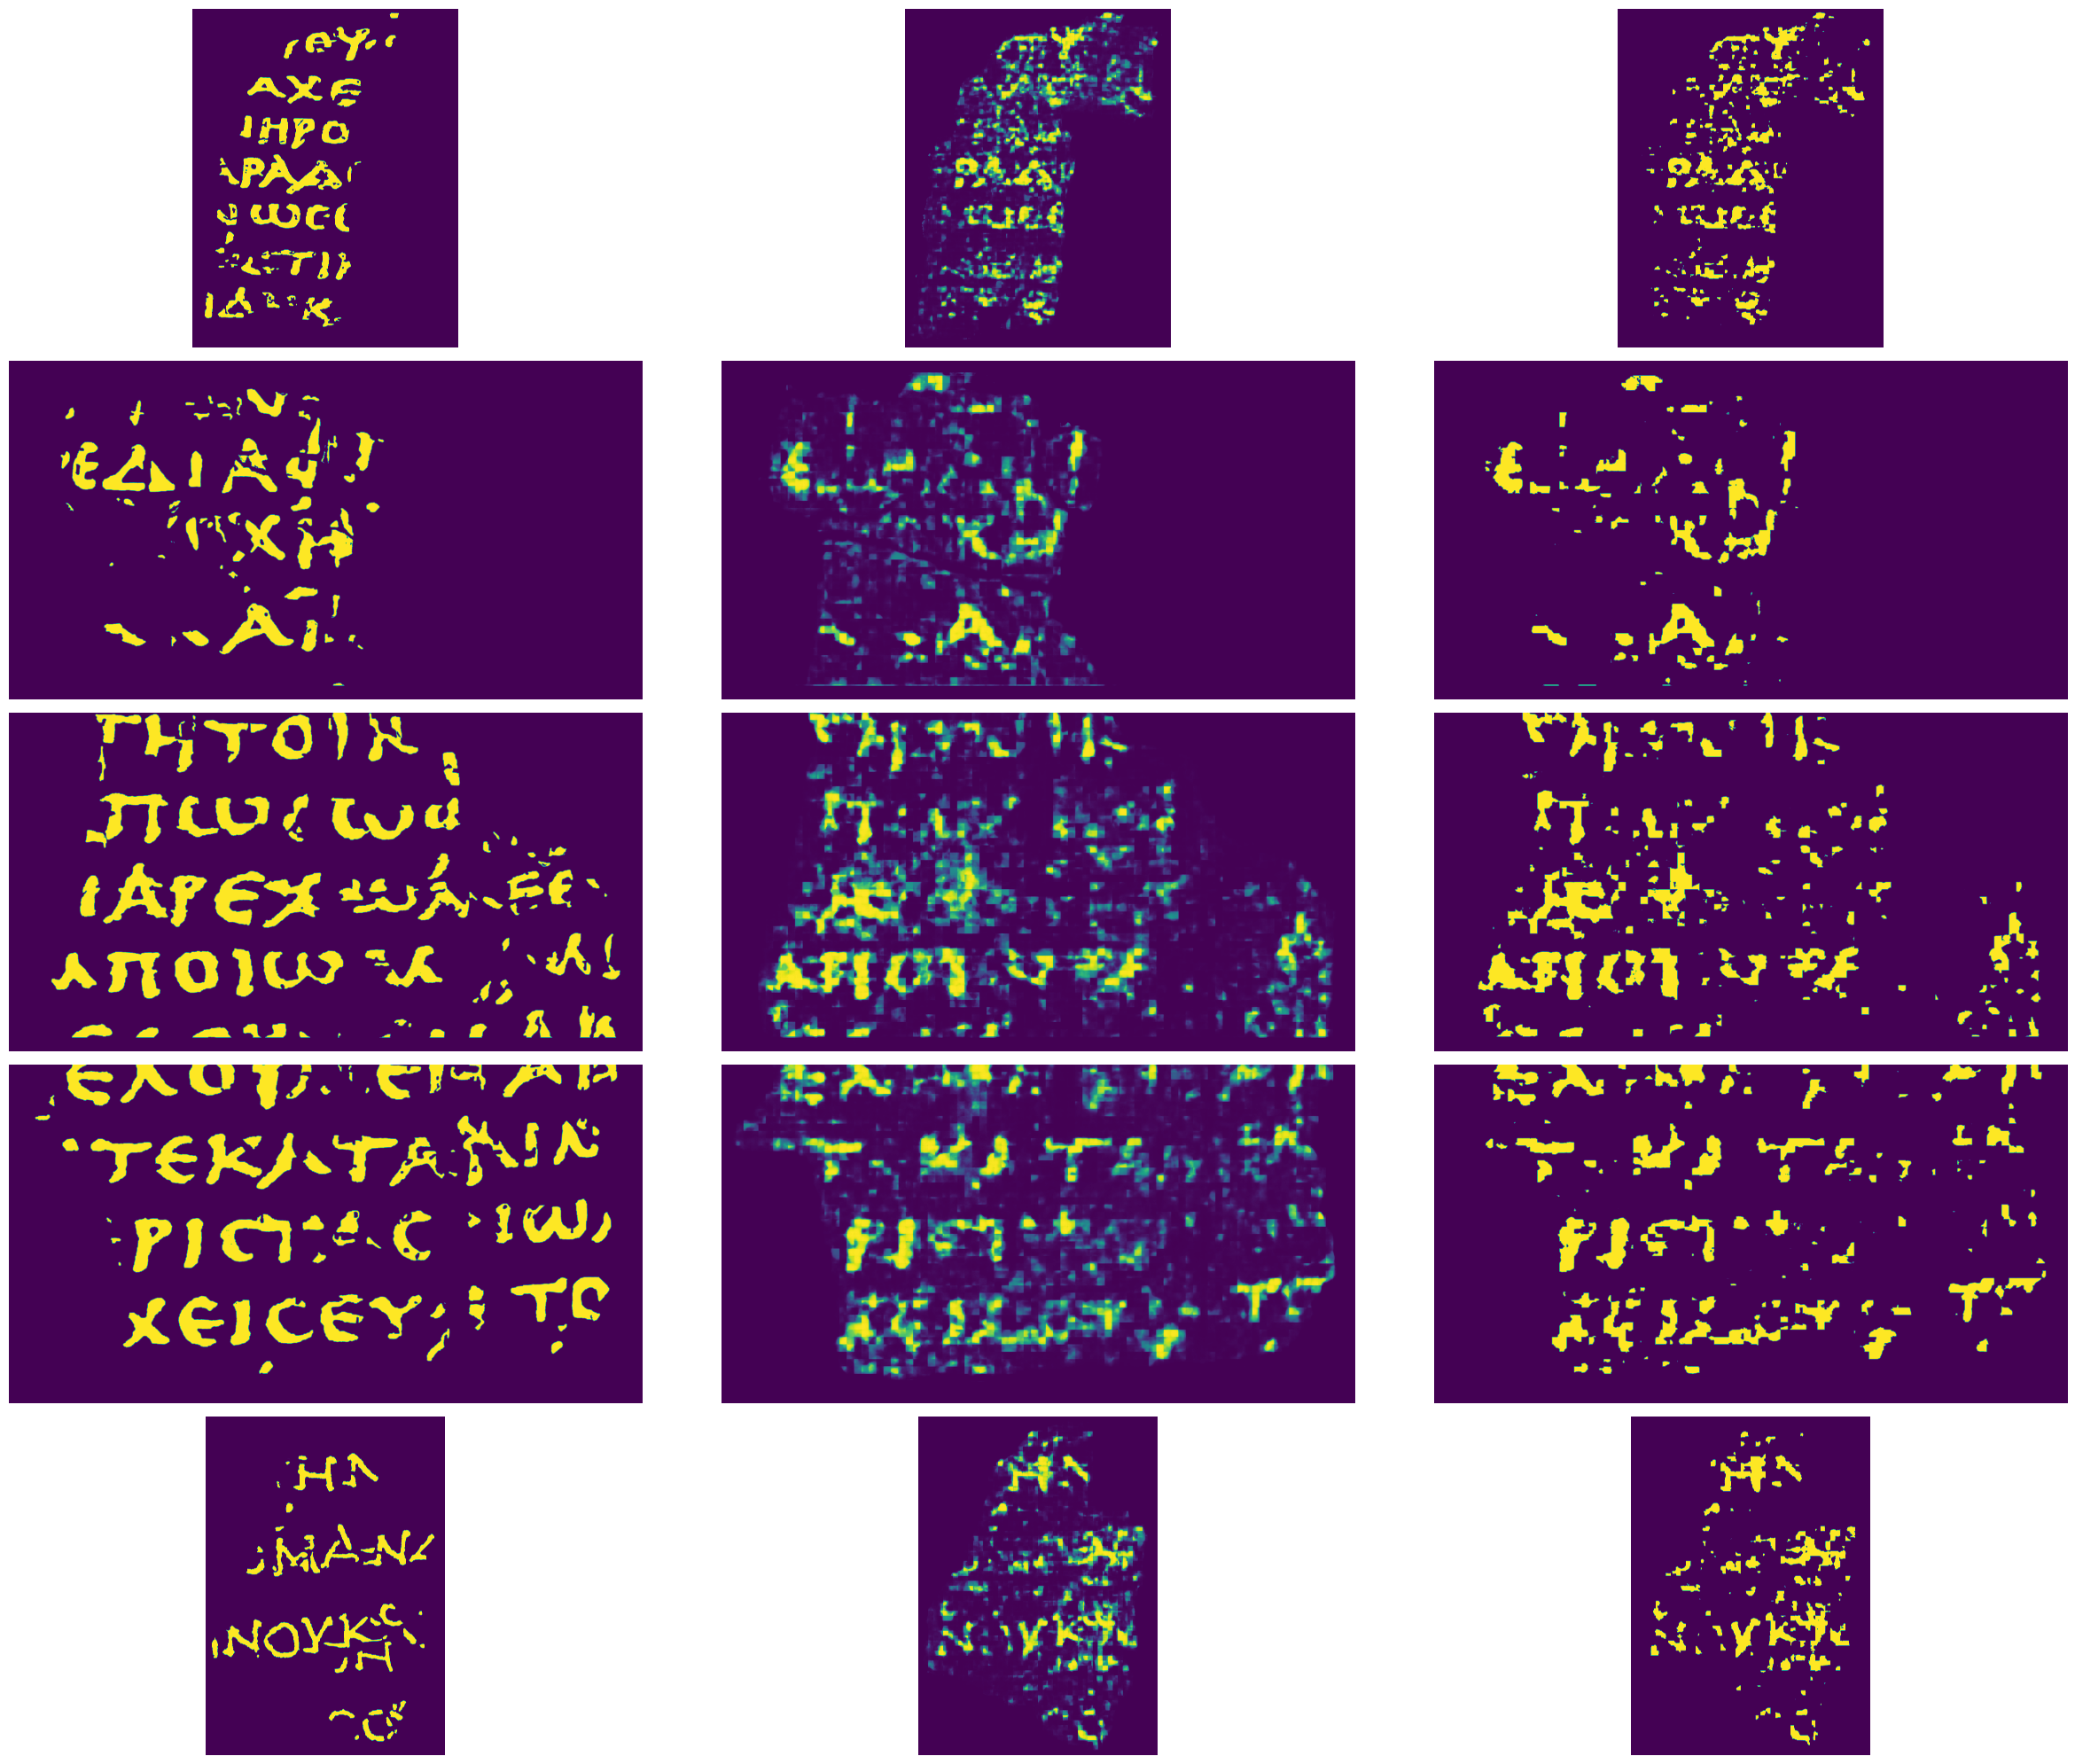

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)